In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import torch

from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx

In [3]:
import numpy as np
print("NumPy version:", np.__version__)

NumPy version: 2.0.2


In [4]:
def visualize_graph(G, color):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, seed=42),  # 生成图的布局
        with_labels=False,
        node_color=color,
        cmap="Set2"  # 颜色映射
    )
    plt.show()

def visualize_embedding(h, color, epoch = None, Loss = None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap='Set2')
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()


In [5]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

print(dataset)                 # 输出数据集名称
print(len(dataset))            # 数据集包含的样本数
print(dataset.num_features)    # 每个节点的特征数
print(dataset.num_classes)     # 数据集中的类别数
data = dataset[0]  # 读取第一个图样本
data

KarateClub()
1
34
4


Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [6]:
edge_index = data.edge_index
edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

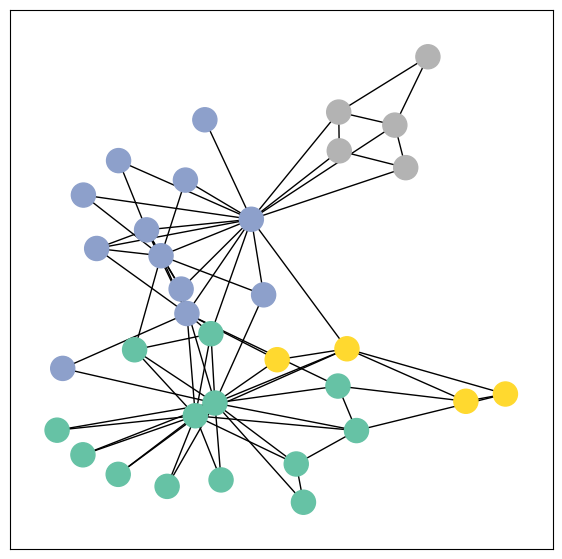

In [7]:
G = to_networkx(dataset[0], to_undirected=True)  # 转换为无向图
visualize_graph(G, color=data.y)  # 使用节点的标签进行可视化

GCN训练

In [10]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

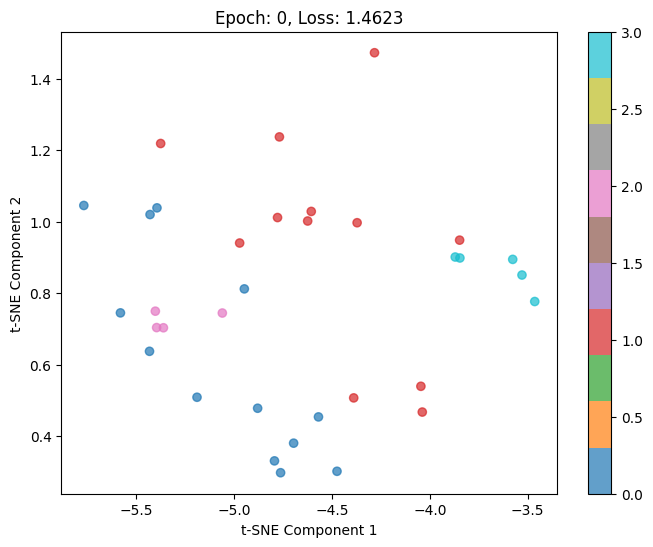

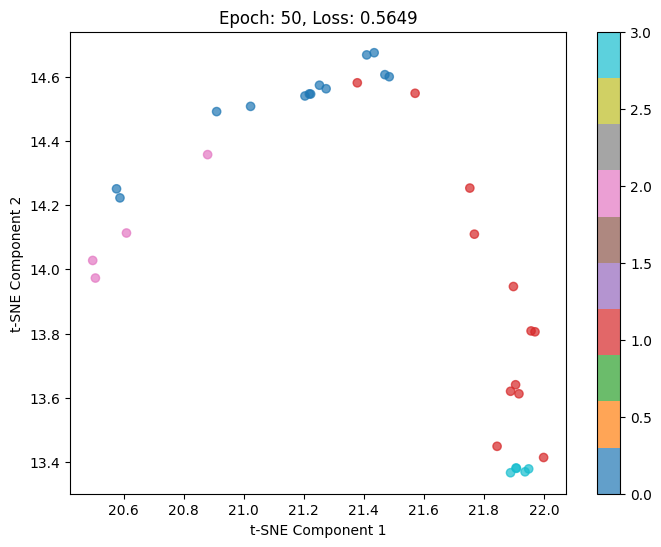

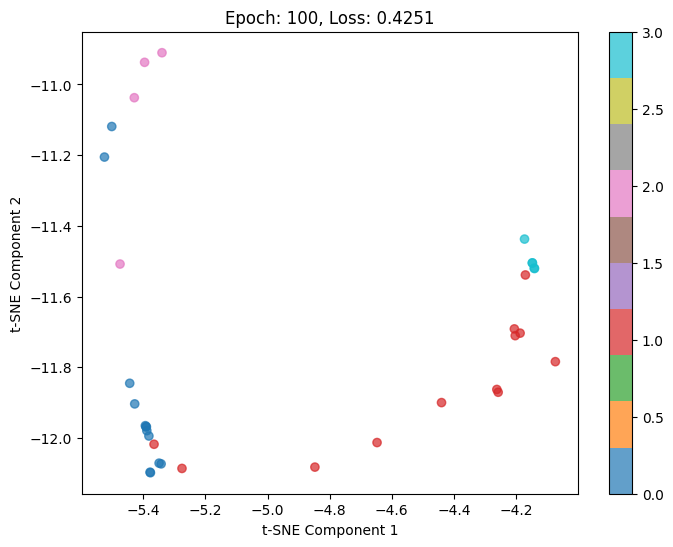

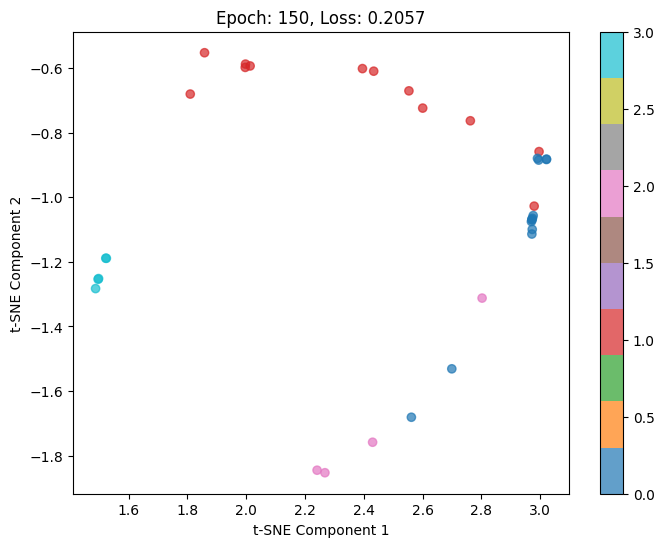

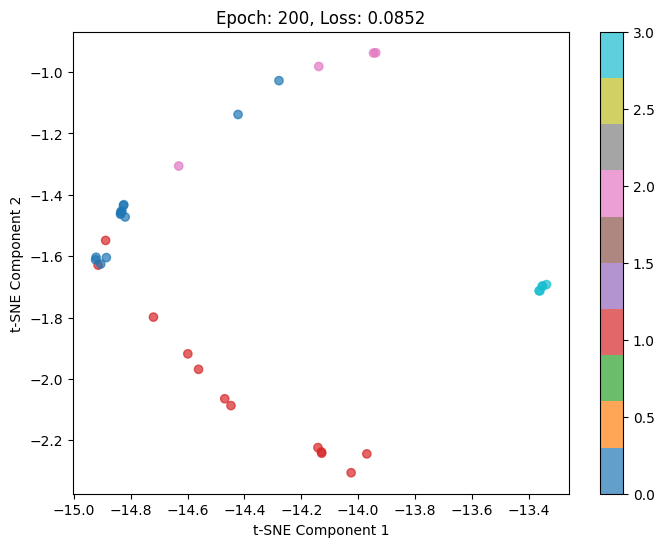

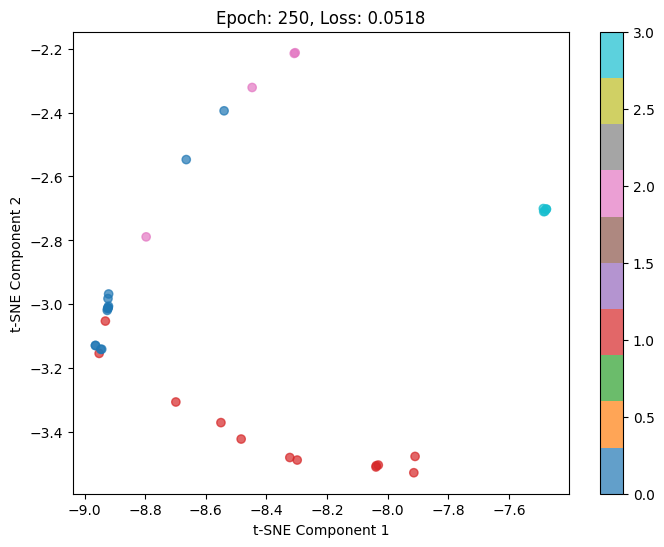

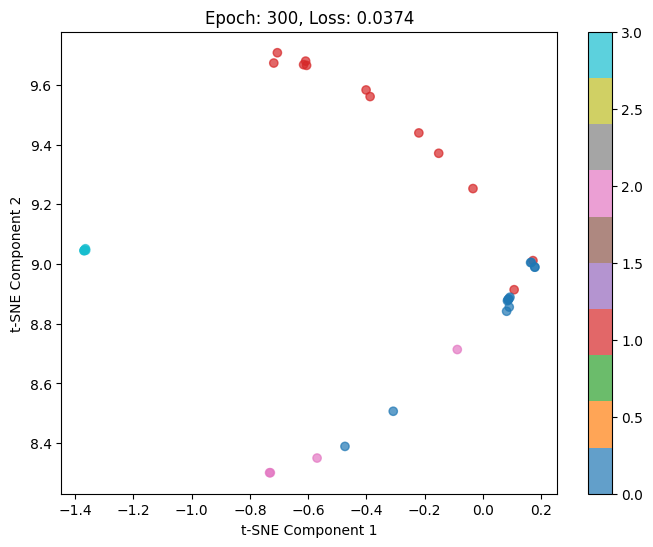

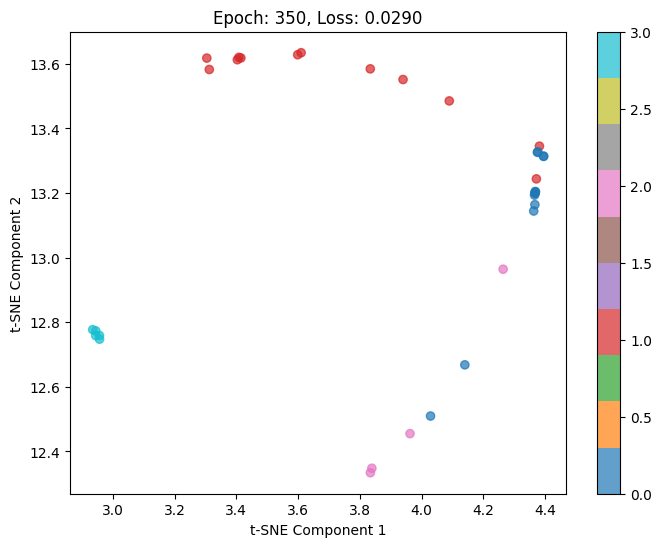

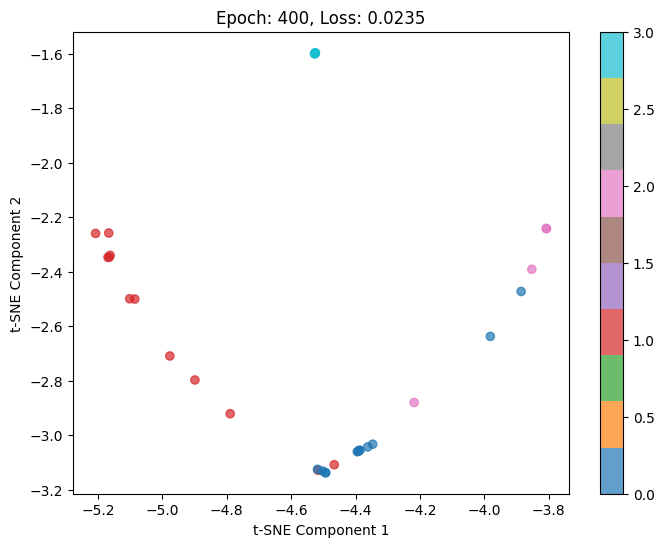

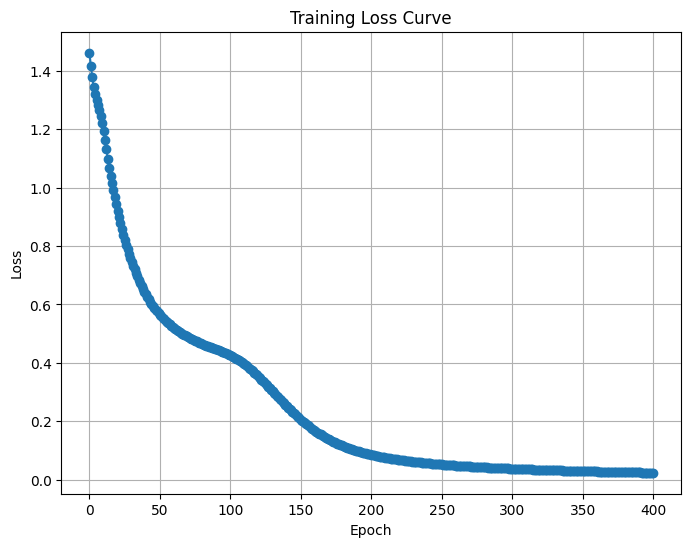

In [23]:
import time
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 定义 GCN 模型
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()
        out = self.classifier(h)
        return out, h

# 创建 GCN 模型实例
model = GCN()

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 可视化嵌入特征
def visualize_embedding(h, color, epoch, loss=None):
    """
    使用 t-SNE 和 Matplotlib 可视化嵌入特征 h
    """
    h = h.detach().cpu().numpy()  # 转换张量为 NumPy 数组
    color = color.detach().cpu().numpy()  # 转换标签为 NumPy 数组

    # 使用 t-SNE 将高维特征降到二维
    tsne = TSNE(n_components=2, random_state=42)
    h_2d = tsne.fit_transform(h)

    # 绘制 t-SNE 的二维结果
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(h_2d[:, 0], h_2d[:, 1], c=color, cmap="tab10", alpha=0.7)
    plt.colorbar(scatter)
    plt.title(f"Epoch: {epoch}, Loss: {loss:.4f}")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

# 绘制损失曲线
def plot_loss_curve(losses):
    """
    绘制训练过程中损失随 epoch 的变化曲线
    """
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(losses)), losses, marker='o')
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

# 训练函数
def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item(), h

# 训练循环
losses = []  # 用于存储每个 epoch 的损失值
for epoch in range(401):
    loss, h = train(data)
    losses.append(loss)  # 记录损失值
    if epoch % 50 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)  # 调用可视化函数
        time.sleep(0.3)

# 绘制损失曲线
plot_loss_curve(losses)

In [24]:
# Prepare the environment
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

# Load the Cora dataset
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

# Print dataset information
print(dataset)  # Cora dataset name
print(len(dataset))  # Number of graphs in the dataset
print(dataset.num_features)  # Number of node features
print(dataset.num_classes)  # Number of classes

# Read and inspect the first (and only) graph in the dataset
data = dataset[0]
print(data)

Cora()
1
1433
7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Processing...
Done!


In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])
    
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap='Set2')
    plt.show()

Epoch:40, Loss:0.2252
Epoch:80, Loss:0.1335
Epoch:120, Loss:0.0997
Epoch:160, Loss:0.0824
Epoch:200, Loss:0.0767
Epoch:40, Loss:0.4483
Epoch:80, Loss:0.2296
Epoch:120, Loss:0.1773
Epoch:160, Loss:0.1609
Epoch:200, Loss:0.1368


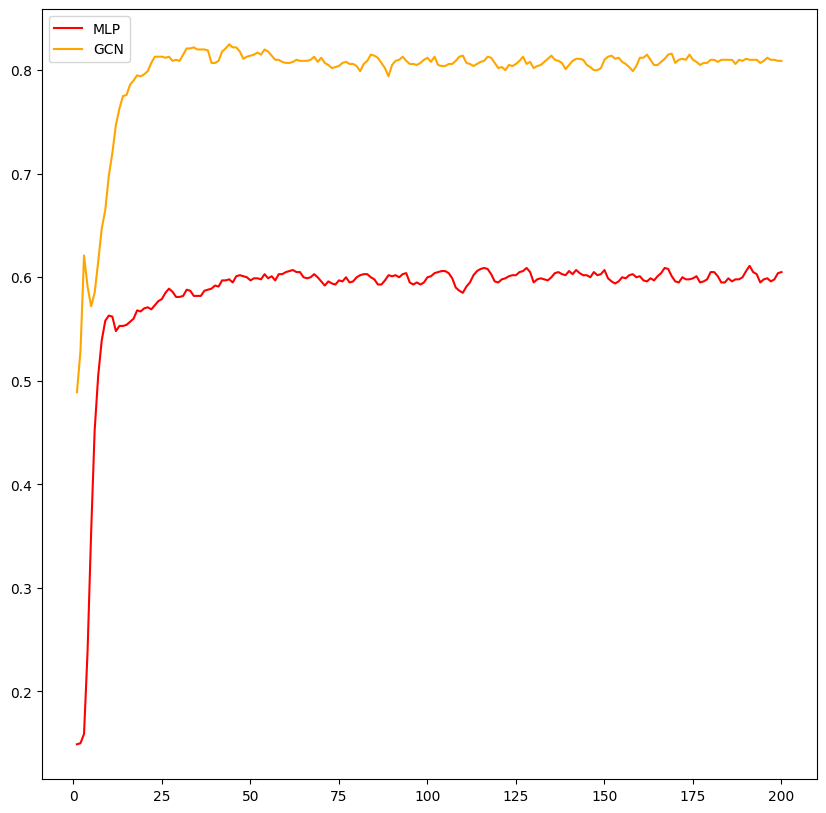

In [26]:
# MLP Implementation
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F

# MLP Class
class MLP(nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

mlp_model = MLP(hidden_channels=128)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    mlp_model.train()
    optimizer.zero_grad()
    out = mlp_model(data.x)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    mlp_model.eval()
    out = mlp_model(data.x)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

mlp_acc = []
for epoch in range(1, 201):
    loss = train()
    if epoch % 40 == 0:
        print(f'Epoch:{epoch}, Loss:{loss:.4f}')
    test_acc = test()
    mlp_acc.append(test_acc)

# GCN Implementation
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, hidden_channel):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channel)
        self.conv2 = GCNConv(hidden_channel, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

gcn_model = GCN(hidden_channel=128)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    gcn_model.train()
    optimizer.zero_grad()
    out = gcn_model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    gcn_model.eval()
    out = gcn_model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

gcn_acc = []
for epoch in range(1, 201):
    loss = train()
    if epoch % 40 == 0:
        print(f'Epoch:{epoch}, Loss:{loss:.4f}')
    test_acc = test()
    gcn_acc.append(test_acc)

# Comparison Visualization
x = [i for i in range(1, 201)]
plt.figure(figsize=(10, 10))
plt.plot(x, mlp_acc, color='red', label='MLP')
plt.plot(x, gcn_acc, color='orange', label='GCN')
plt.legend()
plt.show()

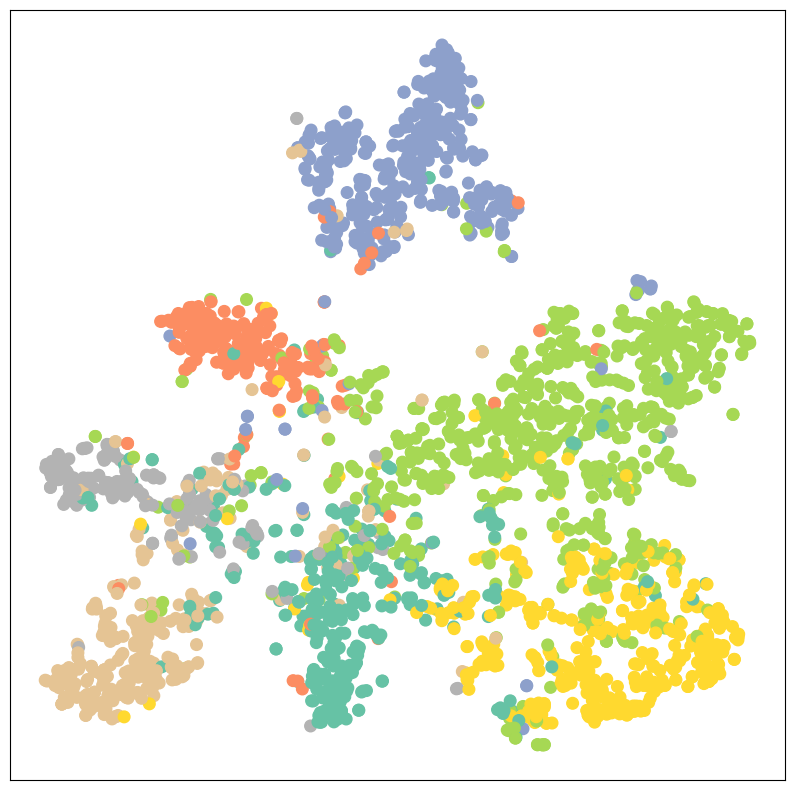

In [30]:
# After training GCN or MLP
# Let's say we visualize GCN's output embeddings:
out = gcn_model(data.x, data.edge_index)

# Define the visualize function
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

visualize(out, color=data.y)